In [ ]:
from transformers import Owlv2Processor, Owlv2ForObjectDetection
from PIL import ImageDraw, Image
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

import torch
import numpy as np

processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

c:\Users\panta\Desktop\owl_model\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


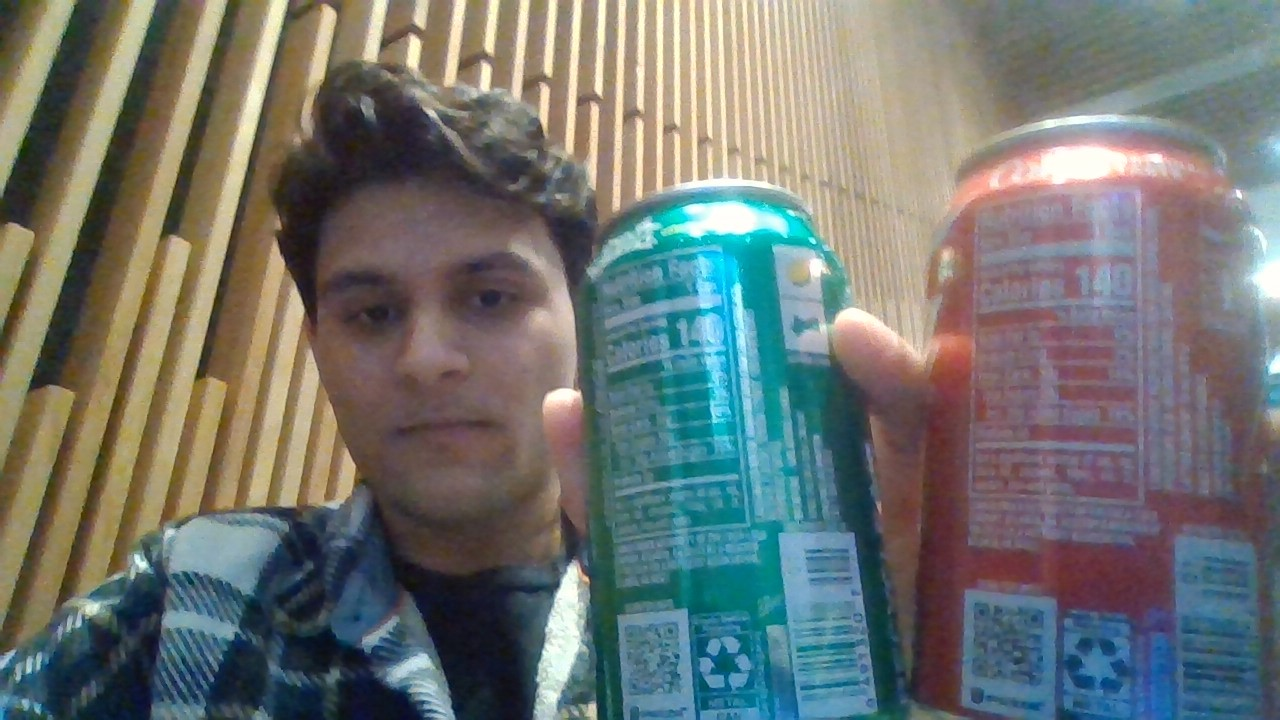

In [ ]:
image = Image.open("./back_can.jpg")
image

In [ ]:
texts = [['a green sprite can']]
inputs = processor(text=texts, images=image, return_tensors="pt")
for k,v in inputs.items():
  print(k,v.shape)

with torch.no_grad():
  outputs = model(**inputs)

input_ids torch.Size([1, 16])
attention_mask torch.Size([1, 16])
pixel_values torch.Size([1, 3, 960, 960])


Detected a green sprite can with confidence 0.355 at location [678.39, 82.42, 961.2, 540.39]
Detected a green sprite can with confidence 0.639 at location [429.43, 133.48, 685.27, 540.8]
tensor([429.4328, 133.4816, 685.2705, 540.7960])


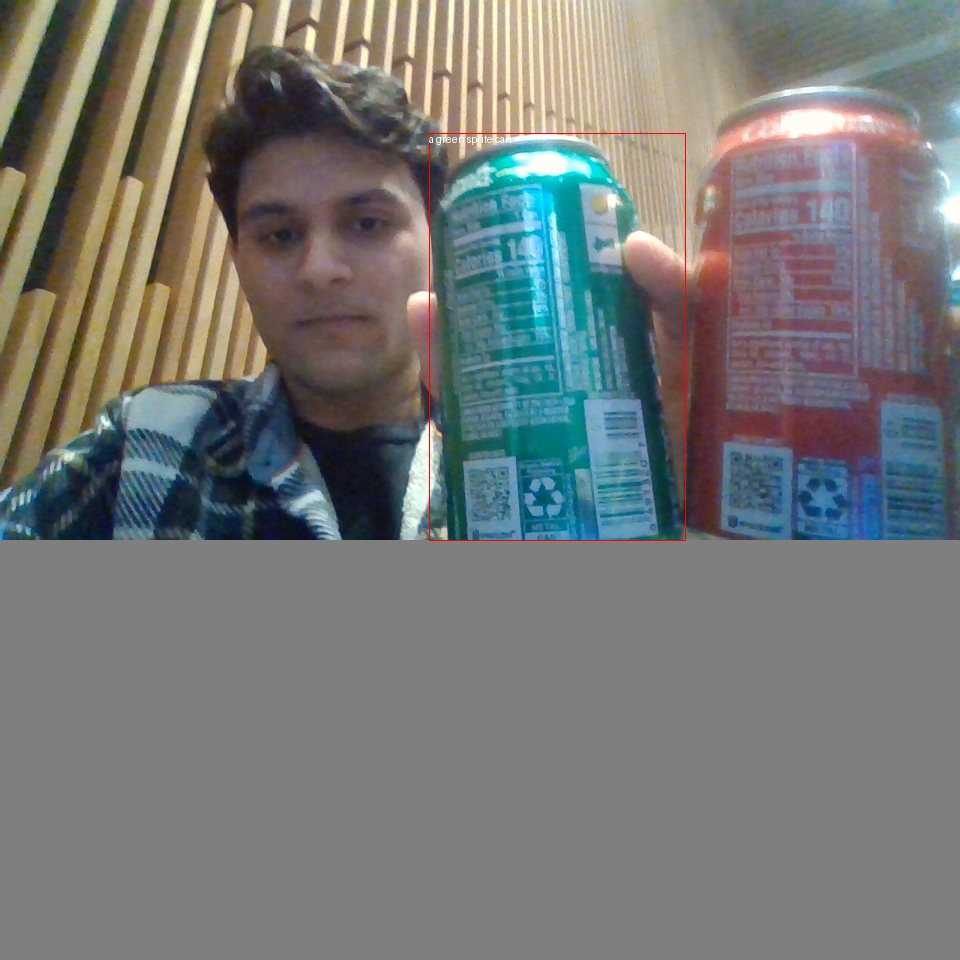

In [ ]:
def get_preprocessed_image(pixel_values):
    pixel_values = pixel_values.squeeze().numpy()
    unnormalized_image = (pixel_values * np.array(OPENAI_CLIP_STD)[:, None, None]) + np.array(OPENAI_CLIP_MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image

unnormalized_image = get_preprocessed_image(inputs.pixel_values)

# Convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.Tensor([unnormalized_image.size[::-1]])
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.2)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")
    
visualized_image = unnormalized_image.copy()

draw = ImageDraw.Draw(visualized_image)

index = np.argmax(scores).numpy()
print(boxes[index])
box = [round(i, 2) for i in boxes[index].tolist()]
x1, y1, x2, y2 = tuple(box)
draw.rectangle(xy=((x1, y1), (x2, y2)), outline="red")
draw.text(xy=(x1, y1), text=text[labels[index]])


# for box, score, label in zip(boxes, scores, labels):
#     if score.numpy() < .5:
#         continue
#     box = [round(i, 2) for i in box.tolist()]
#     x1, y1, x2, y2 = tuple(box)
#     draw.rectangle(xy=((x1, y1), (x2, y2)), outline="red")
#     draw.text(xy=(x1, y1), text=text[label])

visualized_image
